## In this notebook, we are exploring which batters statistics most influence a batter's batting average. We can extend this to slugging and on-base percentage.

Baseball savant released new bat tracking data gathered from high speed Hawkeye camera at baseball stadiums. Bat tracking data became availabe at the start of the 2024 season. (https://www.mlb.com/news/what-you-need-to-know-about-statcast-bat-tracking?partnerId=it-20240513-9833659-mlb-1-A&utm_id=it-20240513-9833659-mlb-1-A&lctg=251114884)



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns


In [22]:
## This is data from the start of the 2024 season, until 5/14/2024.
## it includes those columbs listed below. Need to update this data set. 

batters = pd.read_csv('updated_batter_data.csv')

## have to add in some rows to clean data, we need the columns we need below. 

In [28]:
features = batters.columns.unique()
# batters[['fast_swing_rate']]

## this is giving us an array of the new bat tracking features
features_new = ['avg_swing_speed', 'fast_swing_rate', 'blasts_contact', 'blasts_swing',
       'squared_up_contact', 'squared_up_swing', 'avg_swing_length', 'swords']

## this is giving us the "old" bat tracking, which is stats tracking
## the quality of at bat 
features_quality = ['exit_velocity_avg', 'launch_angle_avg', 'sweet_spot_percent', 'barrel',
       'barrel_batted_rate', 'solidcontact_percent', 'flareburner_percent',
       'poorlyunder_percent', 'poorlytopped_percent', 'poorlyweak_percent',
       'hard_hit_percent']

target = ['batting_avg','slg_percent','on_base_percent']

The data provides the following features that could be used to predict batting average, slugging, onbase, etc. 

### New bat tracking stats: 

- `avg_swing_speed`: the average of the players top 90% of swings. A "fast" swing is 75mph+


- `fast_swing_rate`: the percentage at which the players swing is 75 mph+


- `blasts_contact` a blast is when a batter squares up a ball and does so with a minimum amount of bat speed, the strict definition is (percent squared up)*100 + bat speed >= 164

- `blasts_swing`: a swing that squares up the ball and does so with a fast swing.

- `squared_up_contact`: how much exit velocity did you get as a share of how much exit velocity was possible based on your swing speed and the speed of the pitch. A swing that is 60% squared up, for example, tells you that the batter attained 60% of the maximum possible exit velocity available to him, again based on the speed of the swing and pitch.


- `squared_up_swing`: how much exit velo was attained to how much potential exit velo was possible based on bat speend and pitch speed. 


- `avg_swing_length`: tracks the sum distance traveled by the head of the bat in XYZ space from the start of data until contact point


- `swords` number of swords taken by the batter, which an expression of the art of forcing a batter to take an uncomfortable, awkward swing

### Quality of contact stats

- `exit_velocity_avg`: Exit velocity (how fast, in miles per hour, a ball was hit by a batter) of the batted ball as tracked by Statcast


- `launch_angle_avg`: Launch angle (how high/low, in degrees, a ball was hit by a batter) of the batted ball as tracked by Statcast


- `sweet_spot_percent`: Colloquially, a player who hits the ball solidly is said to have gotten the "sweet spot" of the bat on the ball. The sweet spot classification quantifies that as a batted-ball event with a launch angle ranging from 8 to 32 degrees


- `barrel`: Number of barreled balls. To be Barreled, a batted ball requires an exit velocity of at least 98 mph. At that speed, balls struck with a launch angle between 26-30 degrees always garner Barreled classification. For every mph over 98, the range of launch angles expands.

- `barrel_batted_rate` percentage of balls barreled

- `solidcontact_percent`: essentially any batted ball that falls just short of the requirements necessary to be a Barrel, either because their launch angle isn’t as ideal or because they’re not hit quite hard enough

- `flareburner_percent`: two distinct batted ball types that tend to produce similar results. The exact breakdown can be seen in the formulas shared above, but Burners have higher exit velocities and lower launch angles (e.g. a blistered groundball), and Flares have lower exit velocities and higher launch angles (e.g. a bloop hit that falls between two fielders)

- `poorlyunder_percent`: produce an average launch angle of 45.15 degrees and have the lowest expected batting average of all batted ball types ('got under the ball')

- `poorlytopped_percent`: exclusively comprised of batted balls hit at negative launch angles directly into the ground.

- `poorlyweak_percent`: any ball hit at or below 59 mph, regardless of its launch angle

- `hard_hit_percent`: a hit with an exit velocity of 95 mph or higher, and a player's "hard-hit rate" is simply showing the percentage of batted balls that were hit at 95 mph or more.

### Other stat included:
- `sprint speed`: defined as “feet per second in a player's fastest one-second window” on individual plays.

## Note
Of those stats above, the new bat tracking stats are given by 'bat speend', 'Fast Swing %', 'Blast/Contact', 'Blast/Swing', 'Squared Up/Contact', 'Squared Up/Swing', 'Swing Length', 'Swords'

## EDA 

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [25]:
## split data
batters_train, batters_test = train_test_split(batters,
                                              shuffle = True,
                                              random_state = 555, 
                                              test_size = .2)

In [26]:
batters_train.to_csv('batters_train.csv',index = False)
batters_test.to_csv('batters_test.csv', index = False)

In [29]:
batters_train = batters_train[features_new + features_quality + target].dropna()

In [30]:
batters_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458 entries, 50 to 410
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_swing_speed       458 non-null    float64
 1   fast_swing_rate       458 non-null    float64
 2   blasts_contact        458 non-null    float64
 3   blasts_swing          458 non-null    float64
 4   squared_up_contact    458 non-null    float64
 5   squared_up_swing      458 non-null    float64
 6   avg_swing_length      458 non-null    float64
 7   swords                458 non-null    int64  
 8   exit_velocity_avg     458 non-null    float64
 9   launch_angle_avg      458 non-null    float64
 10  sweet_spot_percent    458 non-null    float64
 11  barrel                458 non-null    int64  
 12  barrel_batted_rate    458 non-null    float64
 13  solidcontact_percent  458 non-null    float64
 14  flareburner_percent   458 non-null    float64
 15  poorlyunder_percent   458 n

In [9]:
# scaler = StandardScaler()
# batters_train_scaled = scaler.fit_transform(batters_train[features])

# batters_train.loc[batters_train.blasts_contact >= 60]
# batters_train.loc[batters_train.blasts_swing >= 40]

# batters_train.loc[batters_train.fast_swing_rate >= 90]

## Plots for the new statcast features

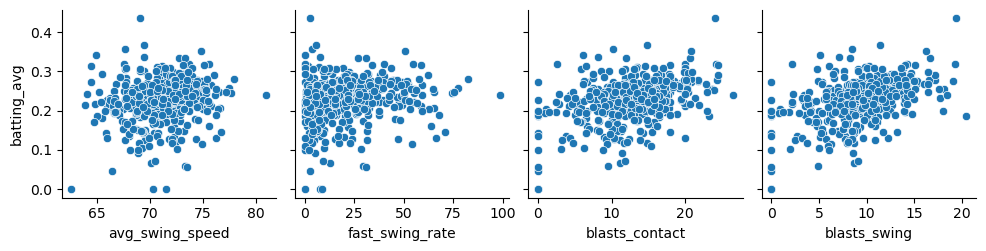

In [31]:
sns.pairplot(batters_train,
#             x_vars = batters_train_scaled[:3],
             x_vars = features_new[:4],
            y_vars = 'batting_avg')

plt.show()

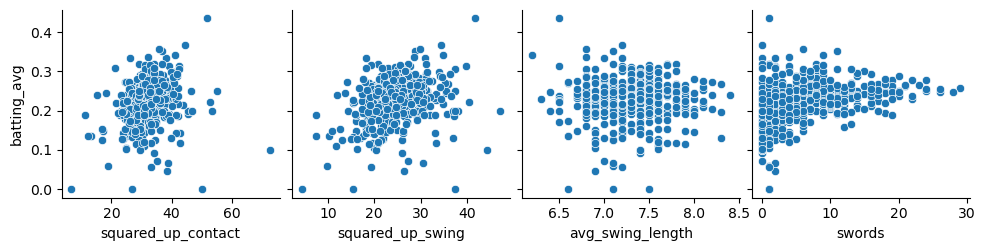

In [32]:
sns.pairplot(batters_train,
             x_vars = features_new[4:],
            y_vars = 'batting_avg')

plt.show()

## Plots for the previous batting statcast features

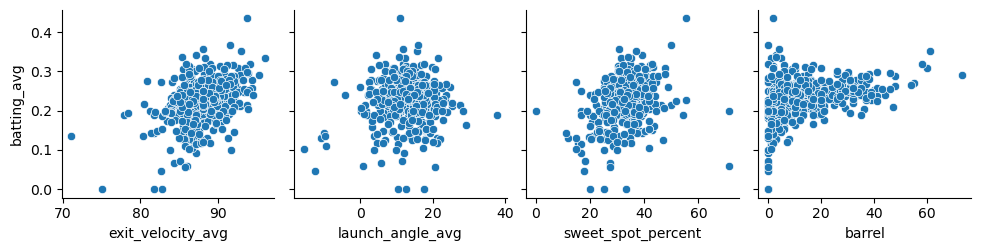

In [33]:
sns.pairplot(batters_train,
             x_vars = ['exit_velocity_avg', 'launch_angle_avg', 'sweet_spot_percent', 'barrel'],
            y_vars = 'batting_avg')

plt.show()

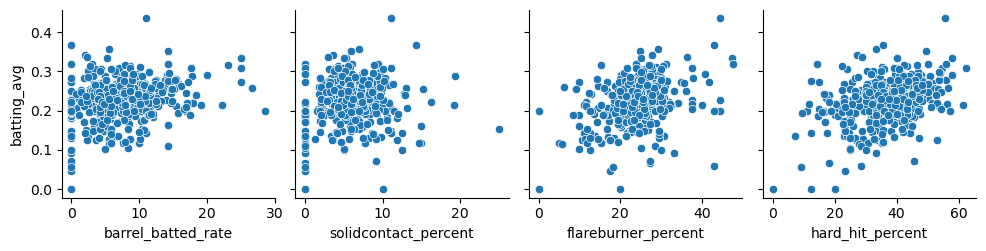

In [34]:
sns.pairplot(batters_train,
             x_vars = ['barrel_batted_rate', 'solidcontact_percent', 'flareburner_percent', 'hard_hit_percent'],
            y_vars = 'batting_avg')

plt.show()

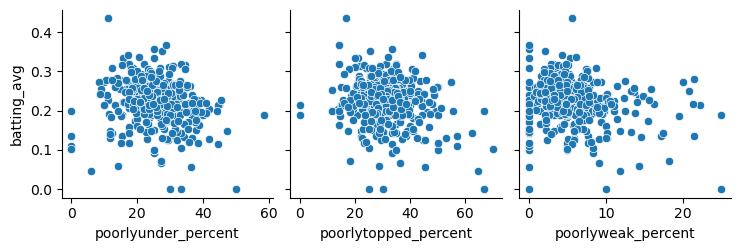

In [36]:
sns.pairplot(batters_train,
             x_vars = ['poorlyunder_percent', 'poorlytopped_percent', 'poorlyweak_percent'],
            y_vars = 'batting_avg')

plt.show()

### Comparing features

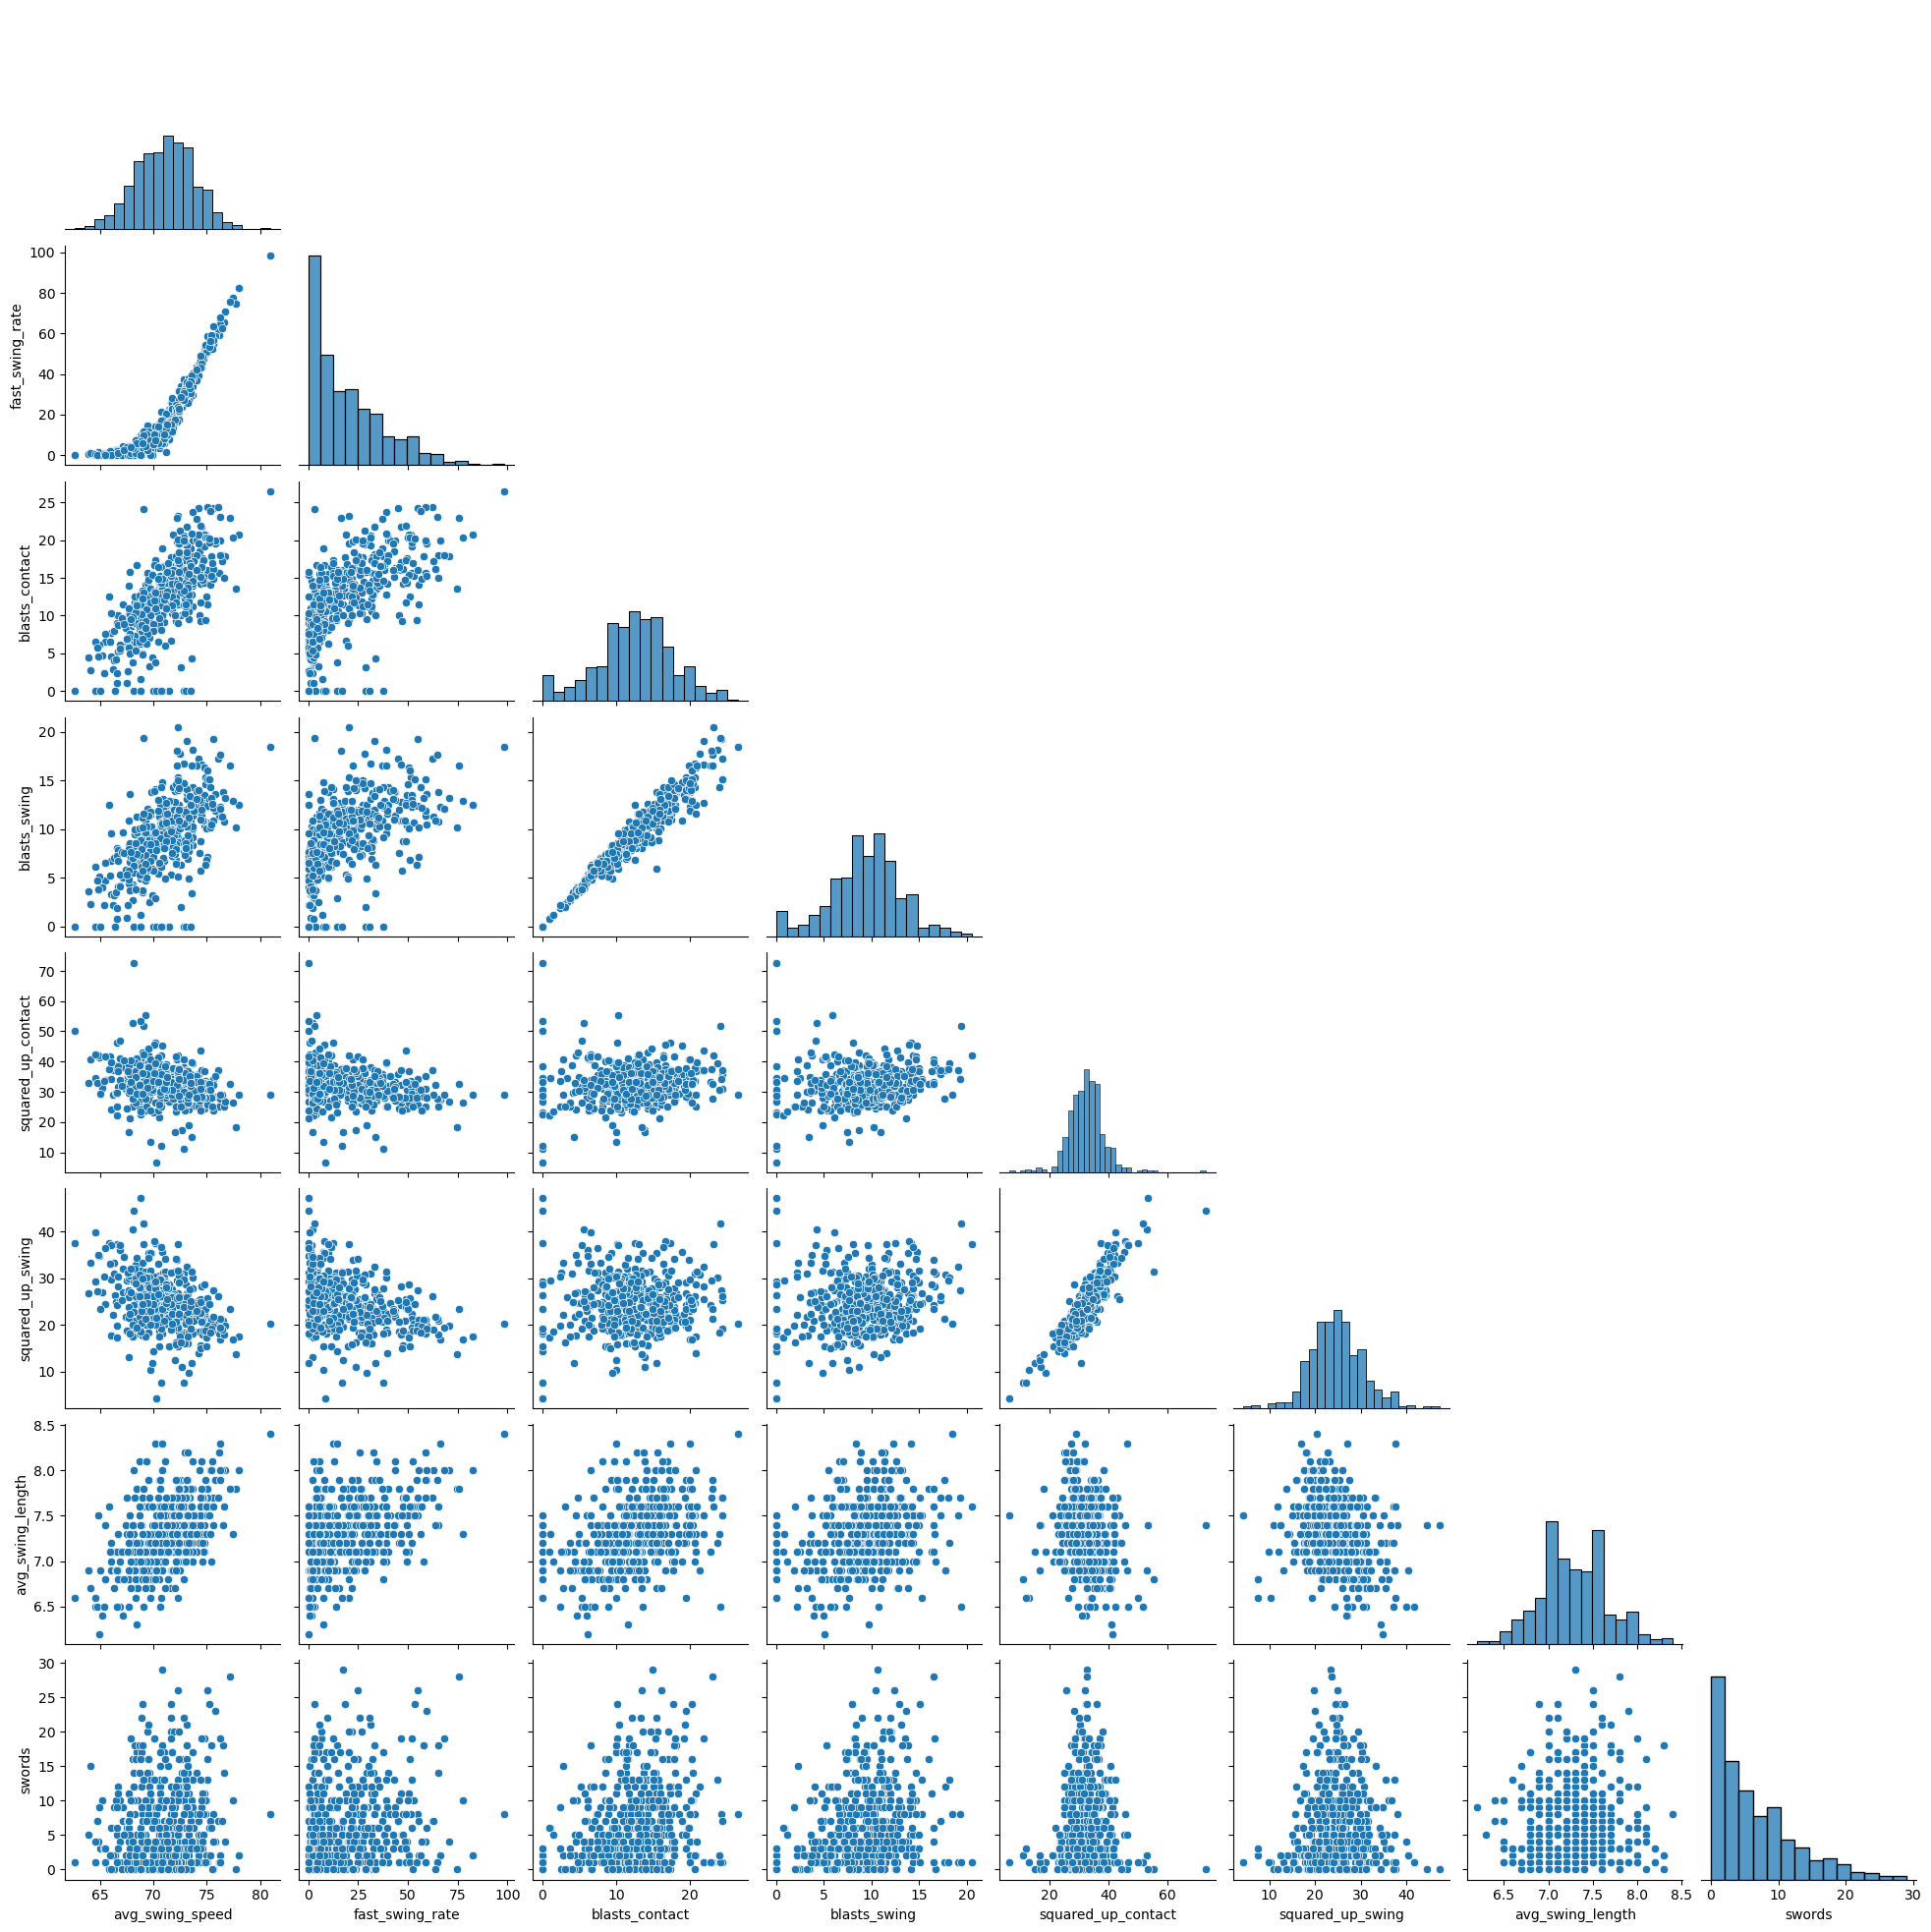

In [37]:
sns.pairplot(batters_train[features_new], corner=True)

plt.show()

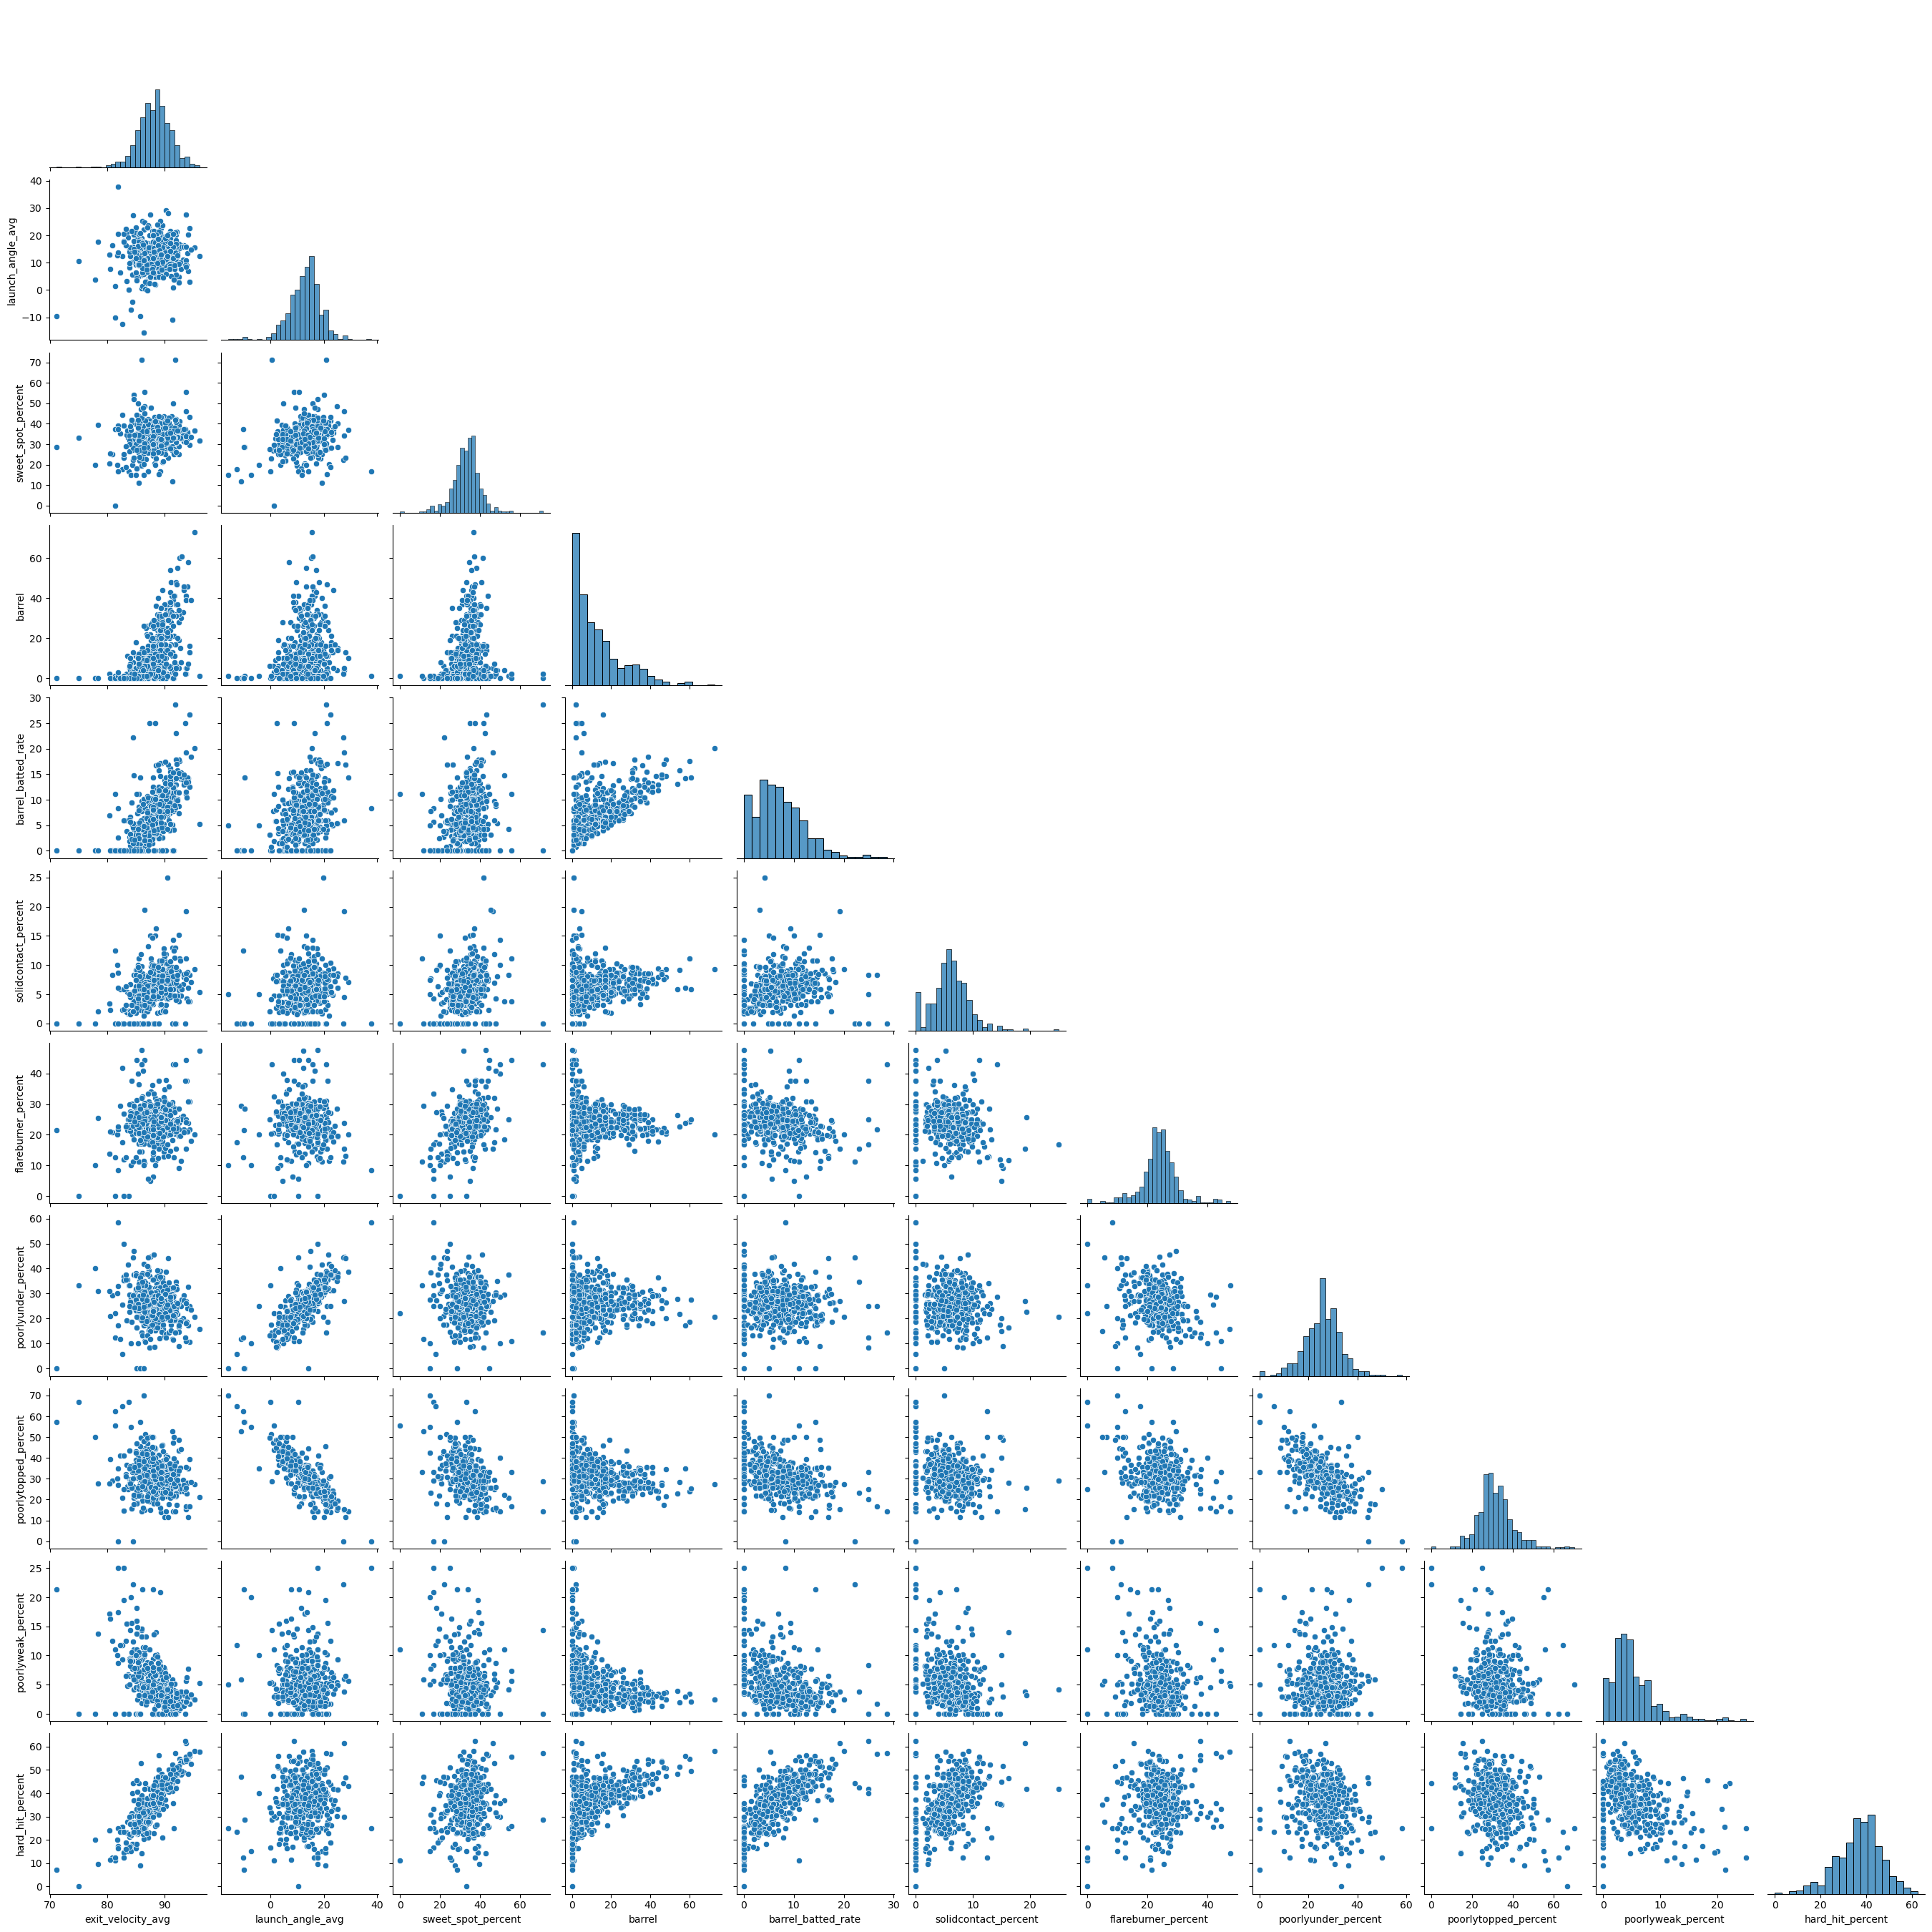

In [38]:
sns.pairplot(batters_train[features_quality], corner=True)

plt.show()

### Correlation coefficients

##### Bat Tracking features

In [39]:
# batters_train[['batting_avg','avg_swing_speed',
#        'fast_swing_rate', 'blasts_contact', 'blasts_swing',
#        'squared_up_contact', 'squared_up_swing', 'avg_swing_length', 'swords',
#        'exit_velocity_avg', 'launch_angle_avg', 'sweet_spot_percent', 'barrel',
#        'barrel_batted_rate', 'solidcontact_percent', 'flareburner_percent',
#        'poorlyunder_percent', 'poorlytopped_percent', 'poorlyweak_percent',
#        'hard_hit_percent','sprint_speed']].corr(method = 'pearson').sort_values('batting_avg', ascending=False)['batting_avg']

batters_train[['batting_avg'] + features_new].corr(method = 'pearson')



,batting_avg,avg_swing_speed,fast_swing_rate,blasts_contact,blasts_swing,squared_up_contact,squared_up_swing,avg_swing_length,swords
batting_avg,1.000000,0.142597,0.152417,0.406171,0.464197,0.223470,0.310672,-0.001028,0.290125
avg_swing_speed,0.142597,1.000000,0.915944,0.685162,0.598646,-0.312885,-0.434602,0.536892,0.130896
fast_swing_rate,0.152417,0.915944,1.000000,0.617109,0.529016,-0.294240,-0.391801,0.486778,0.142528
blasts_contact,0.406171,0.685162,0.617109,1.000000,0.965358,0.112505,0.008471,0.376552,0.236105
blasts_swing,0.464197,0.598646,0.529016,0.965358,1.000000,0.171552,0.161343,0.306077,0.252265
squared_up_contact,0.223470,-0.312885,-0.294240,0.112505,0.171552,1.000000,0.894423,-0.185069,0.014968
squared_up_swing,0.310672,-0.434602,-0.391801,0.008471,0.161343,0.894423,1.000000,-0.286501,0.036174
avg_swing_length,-0.001028,0.536892,0.486778,0.376552,0.306077,-0.185069,-0.286501,1.000000,0.070882
swords,0.290125,0.130896,0.142528,0.236105,0.252265,0.014968,0.036174,0.070882,1.000000


#### Quality of contact features

In [40]:
batters_train[['batting_avg'] + features_quality].corr(method = 'pearson')

,batting_avg,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel,barrel_batted_rate,solidcontact_percent,flareburner_percent,poorlyunder_percent,poorlytopped_percent,poorlyweak_percent,hard_hit_percent
batting_avg,1.000000,0.409808,0.064455,0.289077,0.391989,0.272830,0.119974,0.367333,-0.152005,-0.220669,-0.232075,0.392107
exit_velocity_avg,0.409808,1.000000,0.107276,0.207416,0.555436,0.589312,0.385130,0.165273,-0.153320,-0.217734,-0.521798,0.859464
launch_angle_avg,0.064455,0.107276,1.000000,0.252053,0.206122,0.307464,0.165069,-0.029503,0.768826,-0.826681,-0.023370,0.105847
sweet_spot_percent,0.289077,0.207416,0.252053,1.000000,0.179647,0.262192,0.229364,0.506070,-0.086830,-0.412979,-0.199065,0.216520
barrel,0.391989,0.555436,0.206122,0.179647,1.000000,0.559678,0.197845,-0.030721,0.008070,-0.217336,-0.323229,0.544386
barrel_batted_rate,0.272830,0.589312,0.307464,0.262192,0.559678,1.000000,0.198719,-0.142717,-0.053382,-0.359836,-0.250894,0.687031
solidcontact_percent,0.119974,0.385130,0.165069,0.229364,0.197845,0.198719,1.000000,-0.147450,-0.070289,-0.179773,-0.268043,0.427695
flareburner_percent,0.367333,0.165273,-0.029503,0.506070,-0.030721,-0.142717,-0.147450,1.000000,-0.279483,-0.267361,-0.161203,0.120303
poorlyunder_percent,-0.152005,-0.153320,0.768826,-0.086830,0.008070,-0.053382,-0.070289,-0.279483,1.000000,-0.586938,0.037907,-0.213408
poorlytopped_percent,-0.220669,-0.217734,-0.826681,-0.412979,-0.217336,-0.359836,-0.179773,-0.267361,-0.586938,1.000000,-0.141203,-0.265897


### Thoughts about the above plots
From the stats and plots above, of the new bat tracking features, we should include:

- 'blast swing'
- 'squared up swing'
- 'swords'

From the comparison plot and correlation coeff, 'blast_swing' and 'blast_contact' are strongly correlated (0.96). Same with 'squared_up_contact' and 'squared_up_swing' (0.90). So, we shoud only include one of them each. Also, 'blasts_swing' is more correlated with batting average.

---

For the stats and plots above, of the quality of swing features, it seems as though a batting average model should also include:

- 'exit velo'
- 'sweet spot percentage'
- 'squared up swing' or 'square up contact'
- 'barrel'
- 'flareburner percentage'
- 'hard hit percentage'
- 'poorly topped'
- 'poorly under'
- 'poorly weak'

Let's see what of these identified are correlated.


In [56]:
## lets look to see what are correlated between new and old features: 
potential_features = ['blasts_swing','squared_up_swing','swords','exit_velocity_avg','sweet_spot_percent',
                      'barrel','flareburner_percent','hard_hit_percent','poorlytopped_percent',
                      'poorlyunder_percent','poorlyweak_percent']


In [58]:
batters_train[potential_features].corr(method = 'pearson')

,blasts_swing,squared_up_swing,swords,exit_velocity_avg,sweet_spot_percent,barrel,flareburner_percent,hard_hit_percent,poorlytopped_percent,poorlyunder_percent,poorlyweak_percent
blasts_swing,1.000000,0.161343,0.252265,0.751545,0.121934,0.539191,0.146654,0.823261,-0.143663,-0.250574,-0.349605
squared_up_swing,0.161343,1.000000,0.036174,0.175650,-0.014153,0.032052,0.196431,0.012189,-0.008786,0.024163,-0.091622
swords,0.252265,0.036174,1.000000,0.262854,0.116595,0.601077,0.065521,0.260268,-0.082196,-0.009909,-0.205260
exit_velocity_avg,0.751545,0.175650,0.262854,1.000000,0.207416,0.555436,0.165273,0.859464,-0.217734,-0.153320,-0.521798
sweet_spot_percent,0.121934,-0.014153,0.116595,0.207416,1.000000,0.179647,0.506070,0.216520,-0.412979,-0.086830,-0.199065
barrel,0.539191,0.032052,0.601077,0.555436,0.179647,1.000000,-0.030721,0.544386,-0.217336,0.008070,-0.323229
flareburner_percent,0.146654,0.196431,0.065521,0.165273,0.506070,-0.030721,1.000000,0.120303,-0.267361,-0.279483,-0.161203
hard_hit_percent,0.823261,0.012189,0.260268,0.859464,0.216520,0.544386,0.120303,1.000000,-0.265897,-0.213408,-0.381212
poorlytopped_percent,-0.143663,-0.008786,-0.082196,-0.217734,-0.412979,-0.217336,-0.267361,-0.265897,1.000000,-0.586938,-0.141203
poorlyunder_percent,-0.250574,0.024163,-0.009909,-0.153320,-0.086830,0.008070,-0.279483,-0.213408,-0.586938,1.000000,0.037907


Blasts swing are correlated with exit velo, barrel, and hard hit percentage since it incorporates those into its definition. Let's remove those. 


potential_features = ['blasts_swing','squared_up_swing','swords','sweet_spot_percent',
                      'flareburner_percent','hard_hit_percent','poorlytopped_percent','poorlyweak_percent']

Next step is to see which of the above features correlate with each other. Can also run some PCA or Regularization to see which features may be important. These can give different models. 

So, lets do this:
- Build a model using only new features, and one using new fatures + quality at bat features. 
- Models we will use:
    - Linear Regression with new tracking stats, then one with both. Using this method since we do want interpretability of which features are important to batting. 
    - Find features using PCA, then build Regression model. We can use this just as a predictor of batting average. 
    - Find a regression model using Huber Regularization since there are some outliers in the data. 
    - Lasso Regression to see which features are more important.
- Compare the previous models. 